# Project description
The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

# Download and prepare the data

In [1]:
# Loading all the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# Loading data

# contract
contract = pd.read_csv('contract.csv',parse_dates = ['BeginDate'],
                       dtype={'Type':'category', 'PaperlessBilling':'category','PaymentMethod':'category'})
# personal
personal = pd.read_csv('personal.csv',dtype={'gender':'category', 'SeniorCitizen':'category','Partner':'category',
                                            'Dependents':'category'})
# internet
internet = pd.read_csv('internet.csv')
# phone
phone = pd.read_csv('phone.csv',dtype={'MultipleLines':'category'})


## Data description
The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

# Preprocesing

## Contract

In [3]:
# Basic data set information
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   category      
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: category(3), datetime64[ns](1), float64(1), object(3)
memory usage: 296.2+ KB


In [4]:
# First rows of the data set
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
# Changing columns names for convenience
contract.rename(columns = {'customerID':'customer_id','BeginDate':'begin_date',
                     'EndDate':'end_date','Type':'type',
                     'PaperlessBilling':'paperless_billing','PaymentMethod':'payment_method',
                     'MonthlyCharges':'monthly_charges','TotalCharges':'total_charges'}, inplace = True)
contract.head(0)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges


**my plan** 
* I want to make a target column called `churn` using the data in `end_date` column.
* I want to make new feature that have the period of the customer subscription.
* For that I have to change the `end_date` column to datetime type and subtract the `begin_date` column.
* I will change the 'No' (witch means that the customer didn't leave) to the last date (current date allegedly).

In [6]:
# Creating churn columns with 1 if the customer left and 0 if he didnt
contract.loc[contract['end_date'] == 'No', 'churn'] = 0
contract.loc[contract['end_date'] != 'No', 'churn'] = 1

In [7]:
# Last date of subscription
contract['begin_date'].max()

Timestamp('2020-02-01 00:00:00')

In [8]:
# searching for clients with no total charges
contract.loc[contract['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,0.0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,0.0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,0.0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,0.0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,0.0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,0.0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,0.0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,0.0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,0.0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,0.0


The clients with no total charges are clients that just been subscribed to the company, so I will change the total charge value to 0

In [9]:
# Changing ' ' to 0 
contract.loc[contract['total_charges'] == ' ', 'total_charges'] = 0

In [10]:
# Changing TotalCharges column to float
contract['total_charges'] = contract['total_charges'].astype(float)

In [11]:
# Replacing 'No' with last date in 'end_date' column
contract['end_date'] = contract['end_date'].replace(['No'], '2020-02-01')

In [12]:
# Changing end_date column type to datetime
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d')

In [13]:
# Creating Active_time column
contract['active_time'] = contract['end_date'] - contract['begin_date']
contract['active_time'] = contract['active_time'].dt.days

In [14]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   category      
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   churn              7043 non-null   float64       
 9   active_time        7043 non-null   int64         
dtypes: category(3), datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 406.3+ KB


In [15]:
# Some statistics
contract.describe()

,monthly_charges,total_charges,churn,active_time
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,0.265370,985.996166
std,30.090047,2266.794470,0.441561,747.587844
min,18.250000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,273.000000
50%,70.350000,1394.550000,0.000000,883.000000
75%,89.850000,3786.600000,1.000000,1676.000000
max,118.750000,8684.800000,1.000000,2191.000000


In [16]:
# Getting rid of irrelevant columns
data = contract.drop(['begin_date','end_date','paperless_billing'], axis=1)
data.head(2)

,customer_id,type,payment_method,monthly_charges,total_charges,churn,active_time
0,7590-VHVEG,Month-to-month,Electronic check,29.85,29.85,0.0,31
1,5575-GNVDE,One year,Mailed check,56.95,1889.50,0.0,1036


In [17]:
# Checking missing values
data_mis = data.isnull().sum().to_frame('missing_values')
data_mis['%'] = round(data.isnull().sum()/len(data),3)*100
data_mis.sort_values(by='%', ascending=False)

,missing_values,%
customer_id,0,0.0
type,0,0.0
payment_method,0,0.0
monthly_charges,0,0.0
total_charges,0,0.0
churn,0,0.0
active_time,0,0.0


### summary
* Changed object columns to category or float type to save memory usage
* Created `churn` target column
* Changed `begin_date` and `end_date` columns to DateTime type
* created `time_active` column
* created new data frame with only relevant features

## personal

In [18]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   customerID     7043 non-null   object  
 1   gender         7043 non-null   category
 2   SeniorCitizen  7043 non-null   category
 3   Partner        7043 non-null   category
 4   Dependents     7043 non-null   category
dtypes: category(4), object(1)
memory usage: 82.8+ KB


In [19]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [20]:
# Changing columns names for convenience
personal.rename(columns = {'customerID':'customer_id','SeniorCitizen':'senior_citizen',
                     'Partner':'partner','Dependents':'dependents'}, inplace = True)
personal.head(0)

,customer_id,gender,senior_citizen,partner,dependents


In [21]:
# Merging data frames
data = data.merge(personal,on='customer_id',how='left')
data.head()

,customer_id,type,payment_method,monthly_charges,total_charges,churn,active_time,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Month-to-month,Electronic check,29.85,29.85,0.0,31,Female,0,Yes,No
1,5575-GNVDE,One year,Mailed check,56.95,1889.50,0.0,1036,Male,0,No,No
2,3668-QPYBK,Month-to-month,Mailed check,53.85,108.15,1.0,61,Male,0,No,No
3,7795-CFOCW,One year,Bank transfer (automatic),42.30,1840.75,0.0,1371,Male,0,No,No
4,9237-HQITU,Month-to-month,Electronic check,70.70,151.65,1.0,61,Female,0,No,No


In [22]:
# Checking missing values
data_mis = data.isnull().sum().to_frame('missing_values')
data_mis['%'] = round(data.isnull().sum()/len(data),3)*100
data_mis.sort_values(by='%', ascending=False)

,missing_values,%
customer_id,0,0.0
type,0,0.0
payment_method,0,0.0
monthly_charges,0,0.0
total_charges,0,0.0
churn,0,0.0
active_time,0,0.0
gender,0,0.0
senior_citizen,0,0.0
partner,0,0.0


## Internet

In [23]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [24]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [25]:
# Changing objects into category
columns = list(internet.drop('customerID', axis=1).columns )
internet[columns] = internet[columns].astype('category')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        5517 non-null   object  
 1   InternetService   5517 non-null   category
 2   OnlineSecurity    5517 non-null   category
 3   OnlineBackup      5517 non-null   category
 4   DeviceProtection  5517 non-null   category
 5   TechSupport       5517 non-null   category
 6   StreamingTV       5517 non-null   category
 7   StreamingMovies   5517 non-null   category
dtypes: category(7), object(1)
memory usage: 81.8+ KB


In [26]:
# Changing columns names for convenience
internet.rename(columns = {'customerID':'customer_id','InternetService':'Internet_Service',
                     'OnlineSecurity':'Online_Security','OnlineBackup':'Online_Backup',
                          'DeviceProtection':'Device_Protection','TechSupport':'Tech_Support',
                          'StreamingTV':'Streaming_TV','StreamingMovies':'Streaming_Movies'}, inplace = True)
internet.columns= internet.columns.str.lower() #Changing col names to lower case letters
internet.head(0)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies


In [27]:
# Merging data frames
data = data.merge(internet,on='customer_id',how='left')
data.head(2)

,customer_id,type,payment_method,monthly_charges,total_charges,churn,active_time,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,Month-to-month,Electronic check,29.85,29.85,0.0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,One year,Mailed check,56.95,1889.50,0.0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No


In [28]:
# Checking missing values
data_mis = data.isnull().sum().to_frame('missing_values')
data_mis['%'] = round(data.isnull().sum()/len(data),3)*100
data_mis.sort_values(by='%', ascending=False)

,missing_values,%
streaming_movies,1526,21.7
streaming_tv,1526,21.7
tech_support,1526,21.7
device_protection,1526,21.7
online_backup,1526,21.7
online_security,1526,21.7
internet_service,1526,21.7
type,0,0.0
dependents,0,0.0
customer_id,0,0.0


## Phone

In [29]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   customerID     6361 non-null   object  
 1   MultipleLines  6361 non-null   category
dtypes: category(1), object(1)
memory usage: 56.0+ KB


In [30]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [31]:
# Changing columns names for convenience
phone.rename(columns = {'customerID':'customer_id','MultipleLines':'multiple_lines'}, inplace = True)
phone.head(0)

,customer_id,multiple_lines


In [32]:
# Merging data frames
data = data.merge(phone,on='customer_id',how='left')
data.head(2)

,customer_id,type,payment_method,monthly_charges,total_charges,churn,active_time,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Month-to-month,Electronic check,29.85,29.85,0.0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,One year,Mailed check,56.95,1889.50,0.0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No


In [33]:
# Checking missing values
data_mis = data.isnull().sum().to_frame('missing_values')
data_mis['%'] = round(data.isnull().sum()/len(data),3)*100
data_mis.sort_values(by='%', ascending=False)

,missing_values,%
streaming_movies,1526,21.7
streaming_tv,1526,21.7
tech_support,1526,21.7
device_protection,1526,21.7
online_backup,1526,21.7
online_security,1526,21.7
internet_service,1526,21.7
multiple_lines,682,9.7
dependents,0,0.0
customer_id,0,0.0


## Dealing with missing values

* The missing values are from the `internet` and `Phone` data frame wich are smaller then the other two and thus by combining all the data sets we got missing values.


* Because all the columns with the missing values are made of 2 categories I will replace the missing values with the same ratio of the two categories.


* The data already contains the option of customer not using the service under the category "No".
* The missing values are there because the data sets of the services are shorter than the first two.
* So my reason still tells me its better to replace the missing values with random categories with the same ratio of the rest of the set. 
* Either way I checked both options and the results are almost the same so... doesn't really matter in that case.

In [34]:
# function to deal with missing values
def fil_mis(data,column):
    '''
    A function to replce missing values randomly with the same ratio of the categories in the data set 
    '''
    
    category = list(data[column].value_counts(normalize=True).index)
    p = list(data[column].value_counts(normalize=True))
    
    data[column] = data[column].fillna(pd.Series(np.random.choice(category, 
                                                      p=p, size=len(data))))

In [35]:
# Dealing with missing values in all the columns
cols = ['internet_service','online_security','online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines']
for c in cols:
    fil_mis(data,c)

In [36]:
# Checking missing values
data_mis = data.isnull().sum().to_frame('missing_values')
data_mis['%'] = round(data.isnull().sum()/len(data),3)*100
data_mis.sort_values(by='%', ascending=False)

,missing_values,%
customer_id,0,0.0
dependents,0,0.0
streaming_movies,0,0.0
streaming_tv,0,0.0
tech_support,0,0.0
device_protection,0,0.0
online_backup,0,0.0
online_security,0,0.0
internet_service,0,0.0
partner,0,0.0


## searching for anomalies

In [37]:
# Checking for duplicated rows
dup = data.duplicated()
print(f"There are {dup.sum()} duplicated rows in the data frame")

There are 0 duplicated rows in the data frame


In [38]:
# Ploting histograms
def histo(data,col):    
    ax = plt.subplots()
    sns.set(rc={"figure.figsize":(7, 5)})
    sns.histplot(x=col, data=data)
    plt.title(f'{col} histogram', fontsize=14)

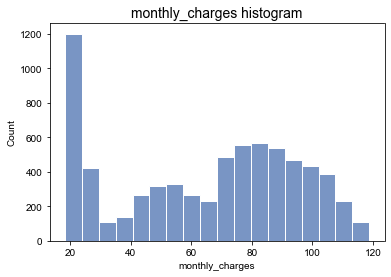

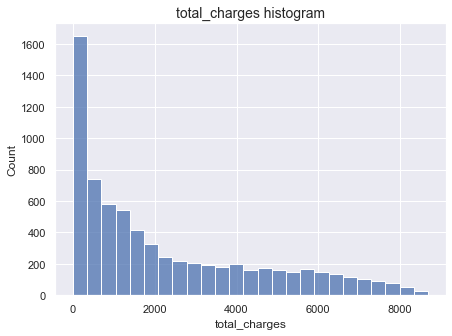

In [39]:
columns = ['monthly_charges', 'total_charges']
for c in columns:
    histo(data,c)

* Both features distributions are right skewed 

Number of anomalies:  0


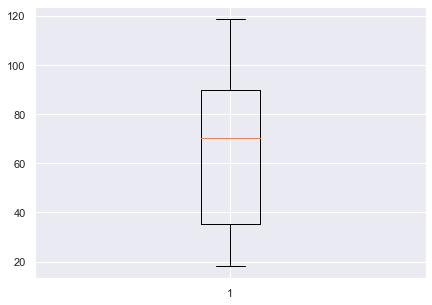

In [40]:
boxplot = plt.boxplot(data['monthly_charges'].values)
outliers = list(boxplot['fliers'][0].get_data()[1])

data_outliers = data[data["monthly_charges"].isin(outliers)]
print('Number of anomalies: ', len(data_outliers))

Number of anomalies:  0


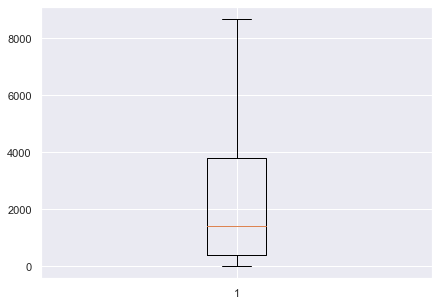

In [41]:
boxplot = plt.boxplot(data['total_charges'].values)
outliers = list(boxplot['fliers'][0].get_data()[1])

data_outliers = data[data["total_charges"].isin(outliers)]
print('Number of anomalies: ', len(data_outliers))

## Conclusions

* There are no outliers in the data
* The data is ready to be divided to features and target 
* The features need to be encoded and normalize

# Model selection and parameter tuning

**plan**
* I'm going to try different classification algorithms and tune their parameters to find the best model for this task.

In [42]:
# Dividing into target and feature
X = data.drop(['churn','customer_id'], axis=1)
y = data['churn']

In [43]:
# Class balnce
y.value_counts(normalize=True)

0.0    0.73463
1.0    0.26537
Name: churn, dtype: float64

The classes are not balanced!
* For the logistic regression model I will balance them with 'class_weight' parameter
* The other two models can handle unbalanced classes 

In [44]:
# Categorical columns
cat = list(X.drop(['monthly_charges','total_charges','active_time'], axis=1).columns)
cat

['type',
 'payment_method',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

**Encoding categorical features**

In [45]:
# OHE for categorical columns
X_ohe = pd.get_dummies(X, drop_first=True)
X_ohe.head()

,monthly_charges,total_charges,active_time,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,senior_citizen_1,partner_Yes,dependents_Yes,internet_service_Fiber optic,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
0,29.85,29.85,31,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1
1,56.95,1889.50,1036,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0
2,53.85,108.15,61,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0
3,42.30,1840.75,1371,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1
4,70.70,151.65,61,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [46]:
# Spliting the data into training set and test set:
# Without ohe
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12345, stratify= y)

In [47]:
# Spliting the data into training set and test set:
# with OHE
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(
    X_ohe, y, test_size=0.2, random_state=12345, stratify= y)

In [48]:
print('Proportions out of original data')
print(f"TRAINING set:     {X_train.shape[0]/X.shape[0]:.0%}")
print(f"TEST set:         {X_test.shape[0]/X.shape[0]:.0%}")

Proportions out of original data
TRAINING set:     80%
TEST set:         20%


## Logistic regresion

In [49]:
%%time

lr = LogisticRegression(class_weight='balanced',random_state=12345)

params_grid = {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']}
grid = GridSearchCV(lr, param_grid=params_grid, scoring='roc_auc', cv=5)
grid.fit(X_train_ohe,y_train_ohe)

lr_tuned = grid.best_estimator_
best_score = grid.best_score_

print(f"Best AUC score:{best_score:.3f}")
print(f"Best parameters:{grid.best_params_}")

Best AUC score:0.843
Best parameters:{'C': 0.23357214690901212, 'penalty': 'l1', 'solver': 'liblinear'}
Wall time: 6.6 s


## CatboostClasifier

 I tried to train cat boost with parameter `cat_features` and with OHE, The results were the same and it took much longer to Train withouht OHE,  So I stick with OHE.

In [50]:
%%time
model = CatBoostClassifier(custom_metric=['Logloss',
                                          'AUC:hints=skip_train~false'], logging_level='Silent', random_seed=12345)
params_grid = {'learning_rate': [0.03, 0.1],
               'depth': [3,4,5],
              'iterations':[100,300,500]}

search_results=model.grid_search(params_grid,X_train_ohe, y=y_train_ohe
                                      ,cv=5)
best_params =search_results['params']

0:	loss: 0.4148502	best: 0.4148502 (0)	total: 455ms	remaining: 7.73s
1:	loss: 0.3863641	best: 0.3863641 (1)	total: 730ms	remaining: 5.84s
2:	loss: 0.3889306	best: 0.3863641 (1)	total: 1.55s	remaining: 7.75s
3:	loss: 0.3492579	best: 0.3492579 (3)	total: 2.41s	remaining: 8.42s
4:	loss: 0.3692310	best: 0.3492579 (3)	total: 3.78s	remaining: 9.82s
5:	loss: 0.3282468	best: 0.3282468 (5)	total: 5.17s	remaining: 10.3s
6:	loss: 0.4094835	best: 0.3282468 (5)	total: 5.47s	remaining: 8.59s
7:	loss: 0.3797587	best: 0.3282468 (5)	total: 5.87s	remaining: 7.34s
8:	loss: 0.3825964	best: 0.3282468 (5)	total: 6.83s	remaining: 6.83s
9:	loss: 0.3297845	best: 0.3282468 (5)	total: 7.84s	remaining: 6.27s
10:	loss: 0.3617649	best: 0.3282468 (5)	total: 9.44s	remaining: 6.01s
11:	loss: 0.3147798	best: 0.3147798 (11)	total: 10.9s	remaining: 5.45s
12:	loss: 0.4040732	best: 0.3147798 (11)	total: 11.2s	remaining: 4.32s
13:	loss: 0.3737229	best: 0.3147798 (11)	total: 11.6s	remaining: 3.31s
14:	loss: 0.3812079	best: 0

In [51]:
print(f"Best AUC score:{model.get_best_score()['learn']['AUC']:.3f}")
print(f"Best parameters:{best_params}")

Best AUC score:0.982
Best parameters:{'depth': 5, 'iterations': 500, 'learning_rate': 0.1}


## LGBMClassifier

In [52]:
%%time

model_2 = LGBMClassifier(random_state=12345)

params_grid = {'learning_rate': [0.03, 0.1],
               'max_depth': [3,4,5],
              'n_estimators':[100,300,500]}

grid = GridSearchCV(model_2, param_grid=params_grid, scoring='roc_auc', cv=5)
grid.fit(X_train,y_train)

lgbm_tuned = grid.best_estimator_
best_score = grid.best_score_

print(f"Best AUC score:{best_score:.3f}")
print(f"Best parameters:{grid.best_params_}")

Best AUC score:0.907
Best parameters:{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}
Wall time: 17.8 s


## Conclusion
The best model is the cat boost with 'depth': 5, 'iterations': 500, 'learning_rate': 0.1
`AUC score: 0.976`

# Model testing

In [53]:
# A function to evaluate the model

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Sanity check

In [54]:
# Fitting dummy model
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_ohe, y_train_ohe)

DummyClassifier(strategy='most_frequent')

          train  test
Accuracy   0.73  0.73
F1         0.00  0.00
APS        0.27  0.27
ROC AUC    0.50  0.50


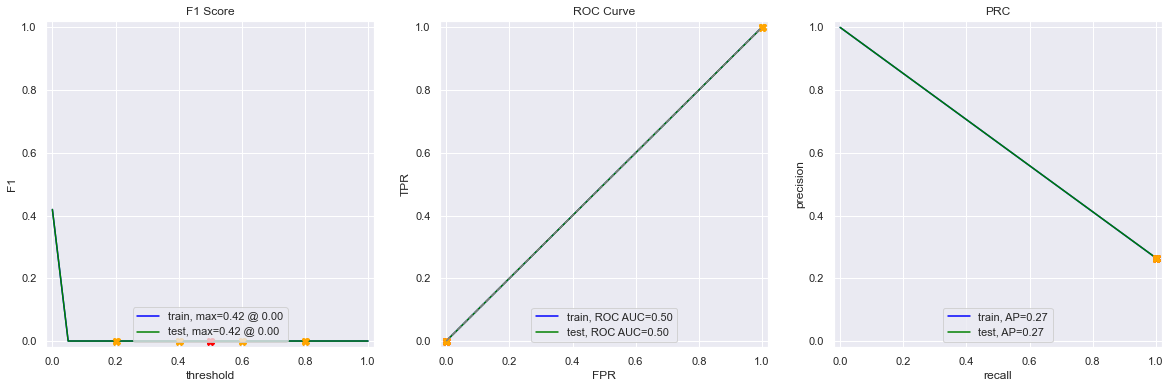

In [55]:
# Evaluating Dummy model
evaluate_model(dummy_clf, X_train_ohe, y_train_ohe, X_test_ohe, y_test_ohe)

## Catboost model

Using the best model I found

In [56]:
model = CatBoostClassifier(custom_metric=['Logloss',
                                          'AUC:hints=skip_train~false'], logging_level='Silent',random_seed=12345,
                      depth =best_params['depth'],iterations = best_params['iterations'],learning_rate=best_params['learning_rate'] )
model.fit(X_train_ohe,y_train_ohe)

          train  test
Accuracy   0.94  0.87
F1         0.88  0.72
APS        0.96  0.83
ROC AUC    0.98  0.91


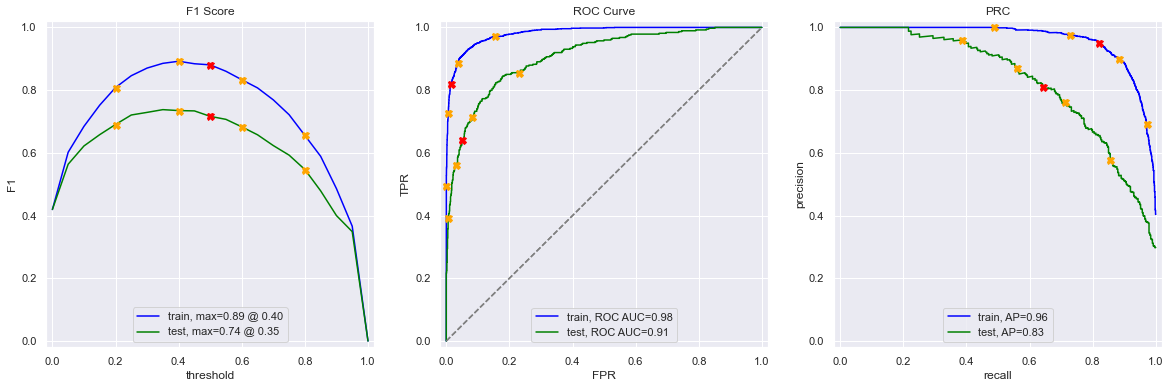

In [57]:
# Model evaluation
evaluate_model(model, X_train_ohe, y_train_ohe, X_test_ohe, y_test_ohe)

# Final Conclusion
* The cat boost model is working great with AUC score of 0.91 on the test set